# Refer-KITTI GT & Prediction Visualization (Clean Version)

This notebook visualizes:

- Ground-truth bounding boxes from Refer-KITTI (`labels_with_ids`)
- GroundingDINO predictions for a referring expression
- Optional: a short video with **GT (green)** and **predictions (blue)** over time


In [3]:
import os
import sys
import json
import random
import glob as _glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import hsv_to_rgb

# For inline video
from IPython.display import Video as IPyVideo

# --- Paths: adjust if needed ---
DATA_ROOT = Path("dataset/referkitti")
IMAGE_ROOT = DATA_ROOT / "KITTI" / "training" / "image_02"
LABEL_ROOT = DATA_ROOT / "KITTI" / "training" / "labels_with_ids" / "image_02"
EXPR_ROOT  = DATA_ROOT / "expression"

print("Using paths:")
print(f"  IMAGE_ROOT = {IMAGE_ROOT}")
print(f"  LABEL_ROOT = {LABEL_ROOT}")
print(f"  EXPR_ROOT  = {EXPR_ROOT}")


Using paths:
  IMAGE_ROOT = dataset/referkitti/KITTI/training/image_02
  LABEL_ROOT = dataset/referkitti/KITTI/training/labels_with_ids/image_02
  EXPR_ROOT  = dataset/referkitti/expression


In [4]:
def load_expressions_for_sequence(expr_root: str, seq: str):
    """Load all referring expressions for a sequence.

    Returns: list of dicts with keys:
        - expr_id
        - text
        - obj_ids  (list[int])
        - label_map (frame_id -> list of target IDs)
        - json_file
    """
    seq_dir = os.path.join(expr_root, seq)
    json_paths = []

    if os.path.isdir(seq_dir):
        json_paths = sorted(_glob.glob(os.path.join(seq_dir, "*.json")))

    single_path = os.path.join(expr_root, f"{seq}.json")
    if os.path.isfile(single_path):
        json_paths.append(single_path)

    if not json_paths:
        return []

    result = []
    expr_counter = 0

    for jp in json_paths:
        with open(jp, "r") as f:
            data = json.load(f)

        # Refer-KITTI style (label + sentence)
        if isinstance(data, dict) and "sentence" in data and "label" in data:
            text = data["sentence"]
            # Convert frame keys to ints for convenience
            raw_label_map = data.get("label", {})
            label_map = {int(k): v for k, v in raw_label_map.items()}

            id_set = set()
            for _, ids in label_map.items():
                if isinstance(ids, (int, str)):
                    id_set.add(int(ids))
                else:
                    for tid in ids:
                        id_set.add(int(tid))

            if id_set:
                result.append({
                    "expr_id": expr_counter,
                    "text": text,
                    "obj_ids": sorted(id_set),
                    "label_map": label_map,
                    "json_file": jp,
                    "seq": seq,
                })
                expr_counter += 1

    return result


def load_frame_labels(labels_root, seq, frame_id):
    """Load YOLO-style labels for a specific frame.

    Label format per line:
        class_id track_id x_center_norm y_center_norm width_norm height_norm
    """
    label_path = os.path.join(labels_root, seq, f"{frame_id:06d}.txt")

    if not os.path.isfile(label_path):
        return []

    labels = []
    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) < 6:
                continue

            try:
                class_id = int(parts[0])
                track_id = int(float(parts[1]))
                x_c = float(parts[2])
                y_c = float(parts[3])
                w = float(parts[4])
                h = float(parts[5])

                labels.append({
                    "class_id": class_id,
                    "track_id": track_id,
                    "x_center": x_c,
                    "y_center": y_c,
                    "width": w,
                    "height": h,
                })
            except ValueError:
                continue

    return labels


def get_color_for_id(track_id, saturation=0.9, value=0.9):
    """Generate a reasonably distinct RGB color for a track ID."""
    hue = (track_id * 0.618033988749895) % 1.0  # golden ratio spacing
    rgb = hsv_to_rgb([hue, saturation, value])
    return rgb


def visualize_frame_with_gt(images_root, labels_root, seq, frame_id,
                            target_ids=None, title=""):
    """Visualize one frame with GT bounding boxes.

    Args:
        target_ids: if provided, only highlight these track IDs
    """
    img_path_png = os.path.join(images_root, seq, f"{frame_id:06d}.png")
    img_path_jpg = os.path.join(images_root, seq, f"{frame_id:06d}.jpg")    

    img = cv2.imread(img_path_png)
    if img is None:
        img = cv2.imread(img_path_jpg)

    if img is None:
        print(f"Could not load image: {img_path_png} or {img_path_jpg}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    labels = load_frame_labels(labels_root, seq, frame_id)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img)

    for lab in labels:
        track_id = lab["track_id"]
        if target_ids is not None and track_id not in target_ids:
            continue

        x_c = lab["x_center"] * W
        y_c = lab["y_center"] * H
        bw  = lab["width"]   * W
        bh  = lab["height"]  * H
        x1 = x_c
        y1 = y_c

        color = get_color_for_id(track_id)

        rect = patches.Rectangle(
            (x1, y1), bw, bh,
            linewidth=2,
            edgecolor=color,
            facecolor='none',
        )
        ax.add_patch(rect)

        label_text = f"ID:{track_id}"
        if target_ids is not None and track_id in target_ids:
            label_text = f"★ {label_text}"

        ax.text(
            x1, y1 - 5,
            label_text,
            color='white',
            fontsize=10,
            bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', pad=1),
        )

    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("Utility functions loaded ✅")


Utility functions loaded ✅


In [7]:
# Discover sequences
all_seqs = sorted([p.name for p in (LABEL_ROOT).iterdir() if p.is_dir()])
print(f"Found {len(all_seqs)} sequences with labels.")


# Load all expressions for these sequences
all_expressions = []
for seq in all_seqs:
    exprs = load_expressions_for_sequence(str(EXPR_ROOT), seq)
    all_expressions.extend(exprs)

print(f"Total expressions: {len(all_expressions)}")


# Sample a few expressions for quick inspection
NUM_SAMPLES = min(10, len(all_expressions))
sampled_expressions = random.sample(all_expressions, NUM_SAMPLES) if all_expressions else []

for i, expr in enumerate(sampled_expressions):
    print("\n" + "="*80)
    print(f"Sample {i+1}/{NUM_SAMPLES}")
    print(f"  Seq:   {expr['seq']}")
    print(f"  Text:  {expr['text']}")
    print(f"  Targets: {expr['obj_ids']}")
    print(f"  JSON:  {expr['json_file']}")


Found 21 sequences with labels.
Total expressions: 818

Sample 1/10
  Seq:   0001
  Text:  vehicles in the counter direction of ours
  Targets: [2, 3, 4, 5, 6, 14, 20, 21, 23, 24, 29, 31, 35, 40, 43, 46, 49, 51, 59, 61, 66, 67, 73, 74, 75, 76, 77, 82, 83, 88, 90, 92, 93, 94, 95]
  JSON:  dataset/referkitti/expression/0001/vehicles-in-the-counter-direction-of-ours.json

Sample 2/10
  Seq:   0013
  Text:  males
  Targets: [99, 101, 112, 114, 117, 118, 120, 121, 122, 123, 137, 141, 142]
  JSON:  dataset/referkitti/expression/0013/males.json

Sample 3/10
  Seq:   0004
  Text:  black cars in the left
  Targets: [1, 4, 6, 9, 20, 29, 31, 34, 41]
  JSON:  dataset/referkitti/expression/0004/black-cars-in-the-left.json

Sample 4/10
  Seq:   0012
  Text:  vehicles
  Targets: [12, 14]
  JSON:  dataset/referkitti/expression/0012/vehicles.json

Sample 5/10
  Seq:   0009
  Text:  light-color cars in the right
  Targets: [1, 8, 25, 30, 51, 57, 58, 67, 70, 73]
  JSON:  dataset/referkitti/expression/000


DEBUG for seq 0001, frame 000204
Image size: W=1242, H=375
Expression: 'vehicles in the counter direction of ours'
Targets: [2, 3, 4, 5, 6, 14, 20, 21, 23, 24, 29, 31, 35, 40, 43, 46, 49, 51, 59, 61, 66, 67, 73, 74, 75, 76, 77, 82, 83, 88, 90, 92, 93, 94, 95]

TrackID  Norm (xc,yc,w,h)                         Pixel (x1,y1,x2,y2)                      Target
-----------------------------------------------------------------------------------------------
59       (0.2480,0.5040,0.0636,0.1173)   (268.5,167.0,347.5,211.0)   ★
61       (0.1892,0.5040,0.0499,0.1013)   (204.0,170.0,266.0,208.0)   ★


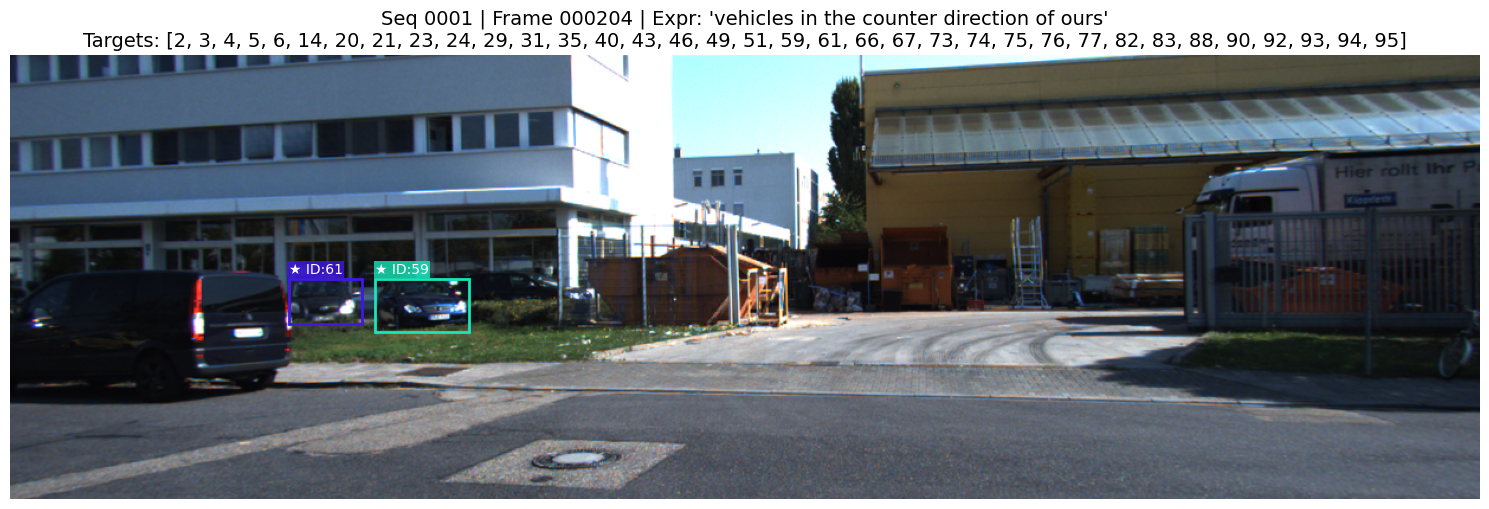

In [8]:
if not sampled_expressions:
    print("No expressions to debug.")
else:
    debug_expr = sampled_expressions[0]
    seq = debug_expr["seq"]
    obj_ids = debug_expr["obj_ids"]
    label_map = debug_expr.get("label_map", {})

    # pick a frame that has targets; fall back to any frame in the sequence
    if label_map:
        frame_ids = sorted(label_map.keys())
    else:
        seq_labels_dir = LABEL_ROOT / seq
        frame_ids = sorted(
            int(p.stem) for p in seq_labels_dir.glob("*.txt")
        )

    if not frame_ids:
        print("No frames found for debug.")
    else:
        frame_id = frame_ids[len(frame_ids)//2]

        # load image to get size
        img_path = IMAGE_ROOT / seq / f"{frame_id:06d}.png"
        if not img_path.exists():
            img_path = IMAGE_ROOT / seq / f"{frame_id:06d}.jpg"

        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Could not load image for frame {frame_id:06d}.")
        else:
            H, W = img.shape[:2]
            labels = load_frame_labels(str(LABEL_ROOT), seq, frame_id)

            print(f"\nDEBUG for seq {seq}, frame {frame_id:06d}")
            print(f"Image size: W={W}, H={H}")
            print(f"Expression: '{debug_expr['text']}'")
            print(f"Targets: {obj_ids}\n")

            print(f"{'TrackID':<8} {'Norm (xc,yc,w,h)':<40} {'Pixel (x1,y1,x2,y2)':<40} Target")
            print("-"*95)
            for lab in labels:
                tid = lab['track_id']
                xcn, ycn, wn, hn = lab['x_center'], lab['y_center'], lab['width'], lab['height']
                xc, yc = xcn*W, ycn*H
                bw, bh = wn*W, hn*H
                x1, y1 = xc-bw/2, yc-bh/2
                x2, y2 = x1+bw, y1+bh
                flag = "★" if tid in obj_ids else ""
                print(f"{tid:<8} ({xcn:.4f},{ycn:.4f},{wn:.4f},{hn:.4f})   ({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})   {flag}")

            title = f"Seq {seq} | Frame {frame_id:06d} | Expr: '{debug_expr['text']}'\nTargets: {obj_ids}"
            visualize_frame_with_gt(str(IMAGE_ROOT), str(LABEL_ROOT), seq, frame_id,
                                    target_ids=set(obj_ids), title=title)


In [9]:
# --- GroundingDINO / RMOT Worker setup ---
sys.path.insert(0, os.path.join(os.getcwd(), 'eval'))
from worker import Worker
import torch

MODEL_CONFIG = {
    "tracker_type": "clip",
    "detector": "dino",
    "config_path": "groundingdino/config/GroundingDINO_SwinB_cfg.py",
    "weights_path": "weights/swinb_light_visdrone_ft_best.pth",  # adjust as needed
    "box_thresh": 0.40,
    "text_thresh": 0.80,
    "track_thresh": 0.45,
    "match_thresh": 0.85,
    "track_buffer": 120,
    "min_box_area": 10,
    "frame_rate": 10,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "use_fp16": True,
    "referring_mode": "topk",
    "referring_topk": 3,
}

print("Model configuration:")
for k, v in MODEL_CONFIG.items():
    print(f"  {k}: {MODEL_CONFIG[k]}")


/isis/home/hasana3/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model configuration:
  tracker_type: clip
  detector: dino
  config_path: groundingdino/config/GroundingDINO_SwinB_cfg.py
  weights_path: weights/swinb_light_visdrone_ft_best.pth
  box_thresh: 0.4
  text_thresh: 0.8
  track_thresh: 0.45
  match_thresh: 0.85
  track_buffer: 120
  min_box_area: 10
  frame_rate: 10
  device: cuda:0
  use_fp16: True
  referring_mode: topk
  referring_topk: 3


In [10]:
from groundingdino.util.inference import load_model, predict
import groundingdino.datasets.transforms as T
from PIL import Image

# simple image transform (same as inference.py)
_gdino_transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


def run_inference_on_frame(worker, img_path):
    """Run GroundingDINO via Worker on a single frame.

    Returns: list of [x1, y1, x2, y2, score] in pixel coordinates.
    """
    image_pil = Image.open(img_path).convert("RGB")
    image_tensor, _ = _gdino_transform(image_pil, None)

    # lazy-load model into worker
    if not hasattr(worker, "model") or worker.model is None:
        worker.model = load_model(MODEL_CONFIG["config_path"], MODEL_CONFIG["weights_path"])
        worker.model = worker.model.to(worker.device)

    boxes, logits, phrases = predict(
        model=worker.model,
        image=image_tensor,
        caption=worker.text_prompt,
        box_threshold=worker.box_thresh,
        text_threshold=worker.text_thresh,
        device=worker.device,
    )

    H, W = image_pil.size[1], image_pil.size[0]  # PIL size = (W, H)
    results = []
    for (x1, y1, x2, y2), score in zip(boxes, logits.sigmoid().cpu().numpy()):
        s = float(score.max())
        results.append([float(x1), float(y1), float(x2), float(y2), s])

    return results


def visualize_prediction_vs_gt(img_path, gt_labels, predictions, target_ids=None, title=""):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W = img.shape[:2]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # --- left: GT ---
    ax = axes[0]
    ax.imshow(img)
    for lab in gt_labels:
        tid = lab["track_id"]
        if target_ids is not None and tid not in target_ids:
            continue
        x_c = lab["x_center"] * W
        y_c = lab["y_center"] * H
        bw  = lab["width"] * W
        bh  = lab["height"] * H
        x1 = x_c 
        y1 = y_c 
        color = get_color_for_id(tid)
        ax.add_patch(patches.Rectangle((x1, y1), bw, bh, linewidth=2, edgecolor=color, facecolor='none'))
        label = f"GT:{tid}"
        ax.text(x1, y1-5, label, color='white', fontsize=9,
                bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', pad=1))
    ax.set_title("Ground Truth")
    ax.axis('off')

    # --- right: predictions ---
    ax = axes[1]
    ax.imshow(img)
    for (x1, y1, x2, y2, score) in predictions:
        x1, y1, x2, y2 = map(float, (x1, y1, x2, y2))
        ax.add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=2, edgecolor='tab:blue', facecolor='none'))
        ax.text(x1, y1-5, f"Pred:{score:.2f}", color='white', fontsize=9,
                bbox=dict(facecolor='tab:blue', alpha=0.8, edgecolor='none', pad=1))
    ax.set_title(f"Predictions ({len(predictions)})")
    ax.axis('off')

    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

print("Inference helpers loaded ✅")


Inference helpers loaded ✅


In [11]:
import tempfile

def create_gt_pred_video_for_expression(expr, max_frames=80, score_thresh=0.3, output_path=None):
    """Create a short MP4 with GT (green) and predictions (blue) for an expression."""
    seq = expr["seq"]
    text = expr["text"]
    target_ids = set(expr["obj_ids"])
    label_map = expr.get("label_map", {})

    # choose frames from label_map if available, otherwise from labels dir
    if label_map:
        frame_ids = sorted(label_map.keys())
    else:
        seq_labels_dir = LABEL_ROOT / seq
        frame_ids = sorted(int(p.stem) for p in seq_labels_dir.glob("*.txt"))

    if not frame_ids:
        print("No frames found for this expression.")
        return None

    frame_ids = frame_ids[:max_frames]

    # load first frame to get size
    first_frame = frame_ids[0]
    img_path = IMAGE_ROOT / seq / f"{first_frame:06d}.png"
    if not img_path.exists():
        img_path = IMAGE_ROOT / seq / f"{first_frame:06d}.jpg"

    frame0 = cv2.imread(str(img_path))
    if frame0 is None:
        print("Could not load first frame image.")
        return None

    H, W = frame0.shape[:2]
    if output_path is None:
        tmpdir = tempfile.mkdtemp(prefix="referkitti_video_")
        output_path = os.path.join(tmpdir, f"{seq}_{first_frame:06d}.mp4")

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(output_path, fourcc, 5, (W, H))

    print(f"Creating video for seq {seq}, expr '{text}' => {len(frame_ids)} frames") 

    for fid in frame_ids:
        img_path = IMAGE_ROOT / seq / f"{fid:06d}.png"
        if not img_path.exists():
            img_path = IMAGE_ROOT / seq / f"{fid:06d}.jpg"

        frame_bgr = cv2.imread(str(img_path))
        if frame_bgr is None:
            continue

        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        H, W = frame_rgb.shape[:2]

        # worker per expression (lazy init once)
        worker = Worker(
            tracker_type=MODEL_CONFIG["tracker_type"],
            detector=MODEL_CONFIG["detector"],
            config_path=MODEL_CONFIG["config_path"],
            weights_path=MODEL_CONFIG["weights_path"],
            box_thresh=MODEL_CONFIG["box_thresh"],
            text_thresh=MODEL_CONFIG["text_thresh"],
            text_prompt=text,
            device=MODEL_CONFIG["device"],
            use_fp16=MODEL_CONFIG["use_fp16"],
            tracker_kwargs={
                "track_thresh": MODEL_CONFIG["track_thresh"],
                "match_thresh": MODEL_CONFIG["match_thresh"],
                "track_buffer": MODEL_CONFIG["track_buffer"],
            },
            min_box_area=MODEL_CONFIG["min_box_area"],
            frame_rate=MODEL_CONFIG["frame_rate"],
            referring_mode=MODEL_CONFIG["referring_mode"],
            referring_topk=MODEL_CONFIG["referring_topk"],
        )

        preds = run_inference_on_frame(worker, str(img_path))
        preds = [p for p in preds if p[4] >= score_thresh]

        # draw GT
        gt_labels = load_frame_labels(str(LABEL_ROOT), seq, fid)
        for lab in gt_labels:
            tid = lab["track_id"]
            if tid not in target_ids:
                continue
            x_c = lab["x_center"] * W
            y_c = lab["y_center"] * H
            bw  = lab["width"] * W
            bh  = lab["height"] * H
            x1 = int(x_c)
            y1 = int(y_c)
            x2 = int(x1 + bw)
            y2 = int(y1 + bh)
            cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame_rgb, f"GT:{tid}", (x1, max(0, y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

        # draw predictions
        for (x1, y1, x2, y2, score) in preds:
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (255, 128, 0), 2)
            cv2.putText(frame_rgb, f"Pred:{score:.2f}", (x1, min(H-5, y2+15)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,128,0), 1, cv2.LINE_AA)

        writer.write(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))

    writer.release()
    print(f"Video saved to: {output_path}")
    return output_path


def show_video_inline(path):
    return IPyVideo(path, embed=True)

print("Video helpers loaded ✅")


Video helpers loaded ✅


In [12]:
if not sampled_expressions:
    print("No expressions loaded.")
else:
    expr = sampled_expressions[0]
    print(f"Using expression: '{expr['text']}' (seq {expr['seq']})")
    video_path = create_gt_pred_video_for_expression(expr, max_frames=40, score_thresh=0.35)
    if video_path:
        show_video_inline(video_path)


Using expression: 'vehicles in the counter direction of ours' (seq 0001)
Creating video for seq 0001, expr 'vehicles in the counter direction of ours' => 40 frames


final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased


final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=3, thresh=0.0
final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased
[Worker] Referring filter enabled: mode=topk, topk=